# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [13]:
from utils import get_dataset
import glob
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import tensorflow as tf

%matplotlib inline

In [3]:
dataset = get_dataset("./data/processed/*.tfrecord")
# ['image', 'source_id', 'key', 'filename', 'groundtruth_image_confidences', 
# 'groundtruth_verified_neg_classes', 'groundtruth_not_exhaustive_classes', 'groundtruth_boxes', 'groundtruth_area', 
# 'groundtruth_is_crowd', 'groundtruth_difficult', 'groundtruth_group_of', 'groundtruth_weights', 'groundtruth_classes',
# 'groundtruth_image_classes', 'original_image_spatial_shape']

#classes = {1: "vehicle", 2: "pedestrian", 4: "cyclist"}

INFO:tensorflow:Reading unweighted datasets: ['./data/processed/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/processed/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 100
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


## Write a function to display an image and the bounding boxes

Implement the `display_instances` function below. This function takes a batch as an input and displays an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [4]:
def display_instances(batch):
    """
    This function takes a batch from the dataset and display the image with 
    the associated bounding boxes.
    """
    
    colormap = {1: [1, 0, 0], 2: [0, 0, 1], 4: [0, 1, 0]}
    
    img = batch['image'].numpy()
    shape = img.shape
    gt_boxes = batch['groundtruth_boxes']
    gt_classes = batch['groundtruth_classes']
    
    #print some useful info
    print('Filename: {}'.format(batch['filename']))
    print('Image shape: {}'.format(shape))
    print('Number of objects: {}'.format(len(gt_boxes)))
    
    fig, ax = plt.subplots(1, figsize=(10,10))
    
    #
    for gt_box, gt_class in zip(gt_boxes, gt_classes):
        anchor = ((shape[1]*gt_box[1]).numpy(), (shape[0] * gt_box[0]).numpy())
        box_w = ((gt_box[3] - gt_box[1]) * shape[1]).numpy()
        box_h = ((gt_box[2] - gt_box[0]) * shape[0]).numpy()
        rect = patches.Rectangle(anchor, box_w, box_h, linewidth=1, edgecolor=colormap[gt_class.numpy()], facecolor='none')
        ax.add_patch(rect)
    
    imgplot = ax.imshow(img)
    plt.axis('off')
    plt.show()

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

Filename: b'segment-10526338824408452410_5714_660_5734_660_with_camera_labels_100.tfrecord'
Image shape: (640, 640, 3)
Number of objects: 17


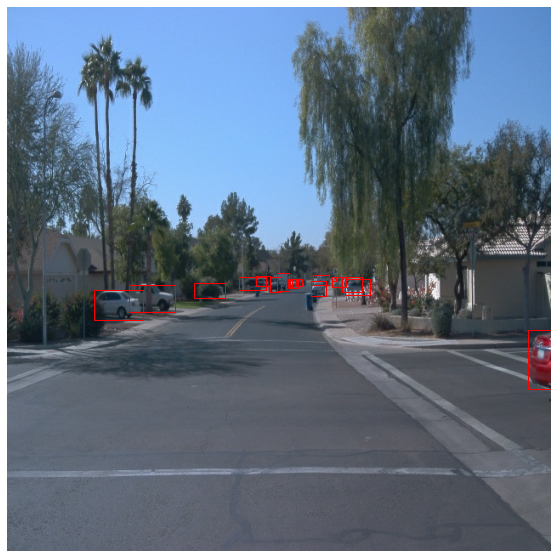

Filename: b'segment-11060291335850384275_3761_210_3781_210_with_camera_labels_50.tfrecord'
Image shape: (640, 640, 3)
Number of objects: 12


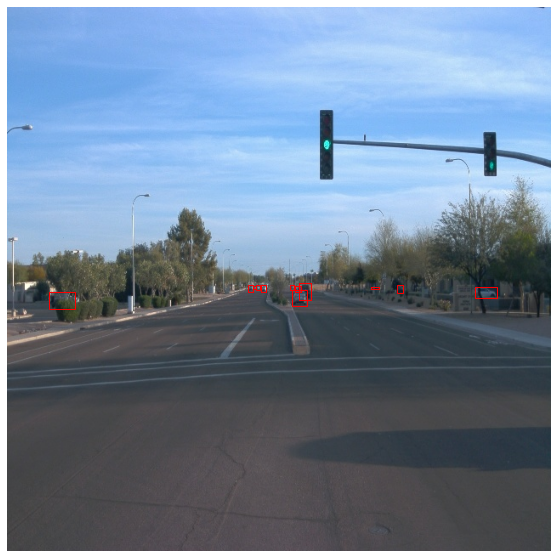

Filename: b'segment-11113047206980595400_2560_000_2580_000_with_camera_labels_70.tfrecord'
Image shape: (640, 640, 3)
Number of objects: 42


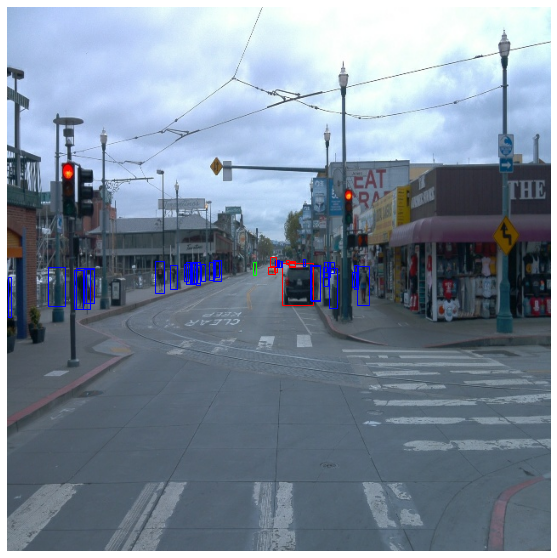

Filename: b'segment-11925224148023145510_1040_000_1060_000_with_camera_labels_160.tfrecord'
Image shape: (640, 640, 3)
Number of objects: 56


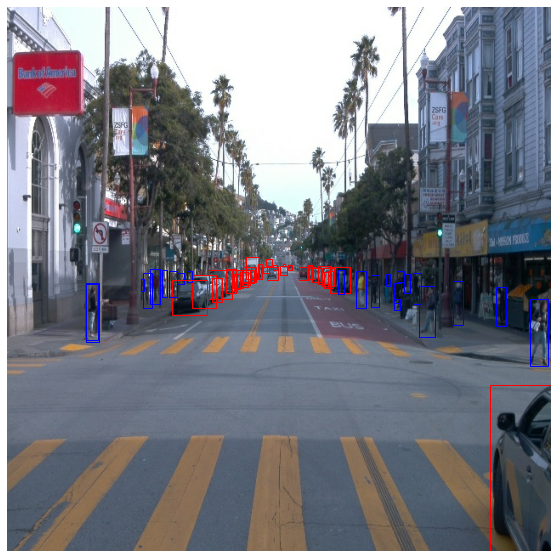

Filename: b'segment-10082223140073588526_6140_000_6160_000_with_camera_labels_90.tfrecord'
Image shape: (640, 640, 3)
Number of objects: 22


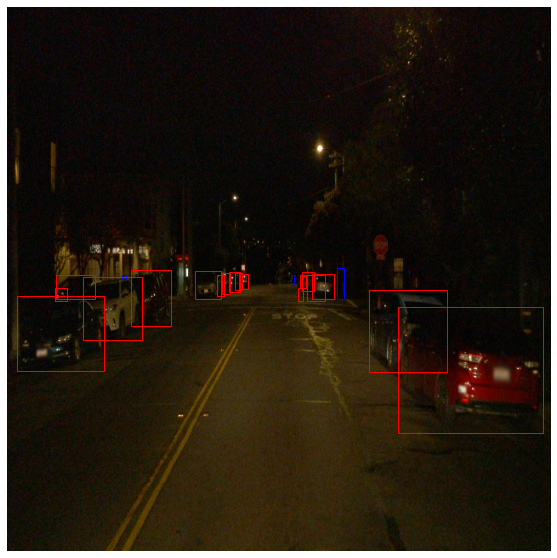

Filename: b'segment-10964956617027590844_1584_680_1604_680_with_camera_labels_110.tfrecord'
Image shape: (640, 640, 3)
Number of objects: 5


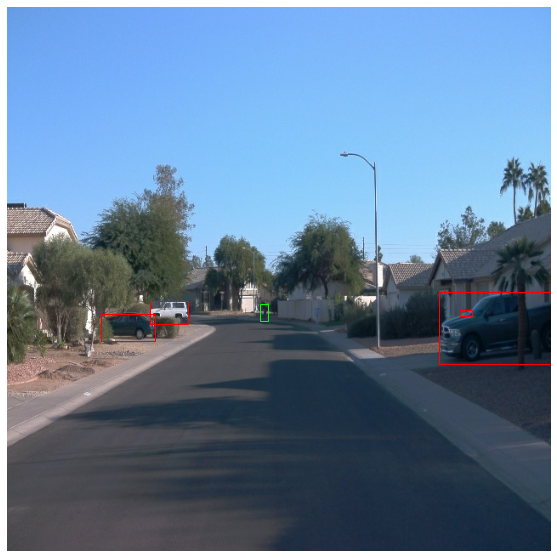

Filename: b'segment-10923963890428322967_1445_000_1465_000_with_camera_labels_10.tfrecord'
Image shape: (640, 640, 3)
Number of objects: 24


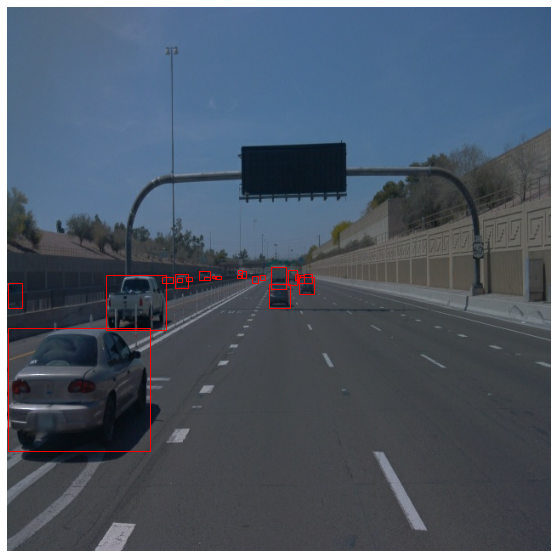

Filename: b'segment-12161824480686739258_1813_380_1833_380_with_camera_labels_0.tfrecord'
Image shape: (640, 640, 3)
Number of objects: 18


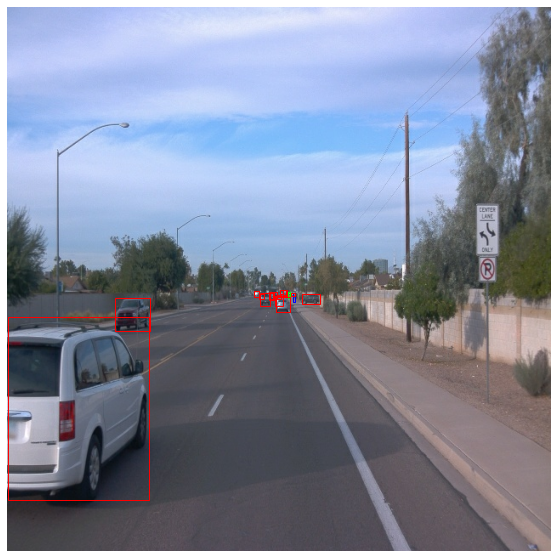

Filename: b'segment-11623618970700582562_2840_367_2860_367_with_camera_labels_150.tfrecord'
Image shape: (640, 640, 3)
Number of objects: 3


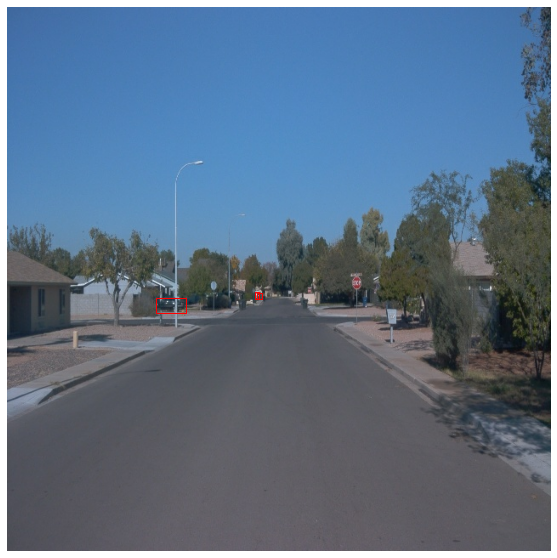

Filename: b'segment-10498013744573185290_1240_000_1260_000_with_camera_labels_50.tfrecord'
Image shape: (640, 640, 3)
Number of objects: 34


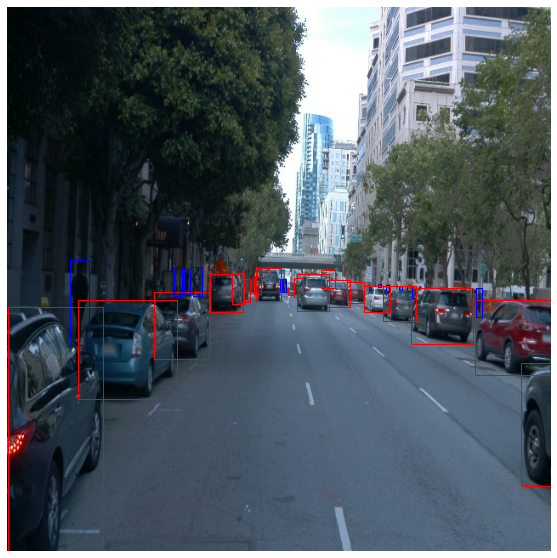

In [5]:
for batch in dataset.shuffle(200, reshuffle_each_iteration=True).take(10):
    display_instances(batch)

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

In [16]:
"""
Other things that might be useful to know:
    1) Distribution of the classes across all records
    2) Distribution of bbox sizes
    3) Distribution of light/dark/blurry images
"""
#initialize some useful stuff
records_glob = glob.glob("./data/processed/*.tfrecord")
classes = {1: "vehicle", 2: "pedestrian", 4: "cyclist"}

#1) Distribution of classes

#get average class counts for first n elements of a given dataset
#chose 10000 for n as a high enough number to get a representative average
def count_classes(dataset, n):
    class_average = {1: 0, 2: 0, 4: 0}
    for element in dataset.take(n):
        bbox_classes = element['groundtruth_classes'].numpy()
        class_average[1] += (bbox_classes == 1).sum()
        class_average[2] += (bbox_classes == 2).sum()
        class_average[4] += (bbox_classes == 4).sum()
    class_average[1] = class_average[1]/n
    class_average[2] = class_average[2]/n
    class_average[4] = class_average[4]/n
    return class_average

#make an array of size m where m is number of tfrecord files
record_averages = {}
for i, record in enumerate(records_glob):
    dataset = get_dataset(record)
    record_averages[i] = count_classes(dataset, 10000)
    
#since this takes a while to run, write to a file for later visualization
with open('Class_Distribution_Raw.json', 'w') as f:
    print(json.dumps(record_averages), file=f)

INFO:tensorflow:Reading unweighted datasets: ['./data/processed/segment-10017090168044687777_6380_000_6400_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/processed/segment-10017090168044687777_6380_000_6400_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['./data/processed/segment-10023947602400723454_1120_000_1140_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/processed/segment-10023947602400723454_1120_000_1140_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['./data/processed/segment-1005081002024129653_5313_150_5333_150_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/processed/segment-1005081002024129653_5313_150_5333_150_with_camera_labels.tfrecord']
INFO:tensorflow:Number of fil

INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['./data/processed/segment-10327752107000040525_1120_000_1140_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/processed/segment-10327752107000040525_1120_000_1140_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['./data/processed/segment-10391312872392849784_4099_400_4119_400_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/processed/segment-10391312872392849784_4099_400_4119_400_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['./data/processed/segment-10444454289801298640_4360_000_4380_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/processed/segment-10444454289801298640_4360_000_4380_000_with_camer

INFO:tensorflow:Reading record datasets for input file: ['./data/processed/segment-10734565072045778791_440_000_460_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['./data/processed/segment-10750135302241325253_180_000_200_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/processed/segment-10750135302241325253_180_000_200_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['./data/processed/segment-10770759614217273359_1465_000_1485_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/processed/segment-10770759614217273359_1465_000_1485_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['./data/processed/segment-10786629299947667143_3440_000_3460_000_with_camera_labe

INFO:tensorflow:Reading unweighted datasets: ['./data/processed/segment-11126313430116606120_1439_990_1459_990_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/processed/segment-11126313430116606120_1439_990_1459_990_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['./data/processed/segment-11139647661584646830_5470_000_5490_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/processed/segment-11139647661584646830_5470_000_5490_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['./data/processed/segment-11183906854663518829_2294_000_2314_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/processed/segment-11183906854663518829_2294_000_2314_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of f

INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['./data/processed/segment-11674150664140226235_680_000_700_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/processed/segment-11674150664140226235_680_000_700_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['./data/processed/segment-11718898130355901268_2300_000_2320_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/processed/segment-11718898130355901268_2300_000_2320_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['./data/processed/segment-1172406780360799916_1660_000_1680_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/processed/segment-1172406780360799916_1660_000_1680_000_with_camera_labe

INFO:tensorflow:Reading record datasets for input file: ['./data/processed/segment-12179768245749640056_5561_070_5581_070_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['./data/processed/segment-12200383401366682847_2552_140_2572_140_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/processed/segment-12200383401366682847_2552_140_2572_140_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1


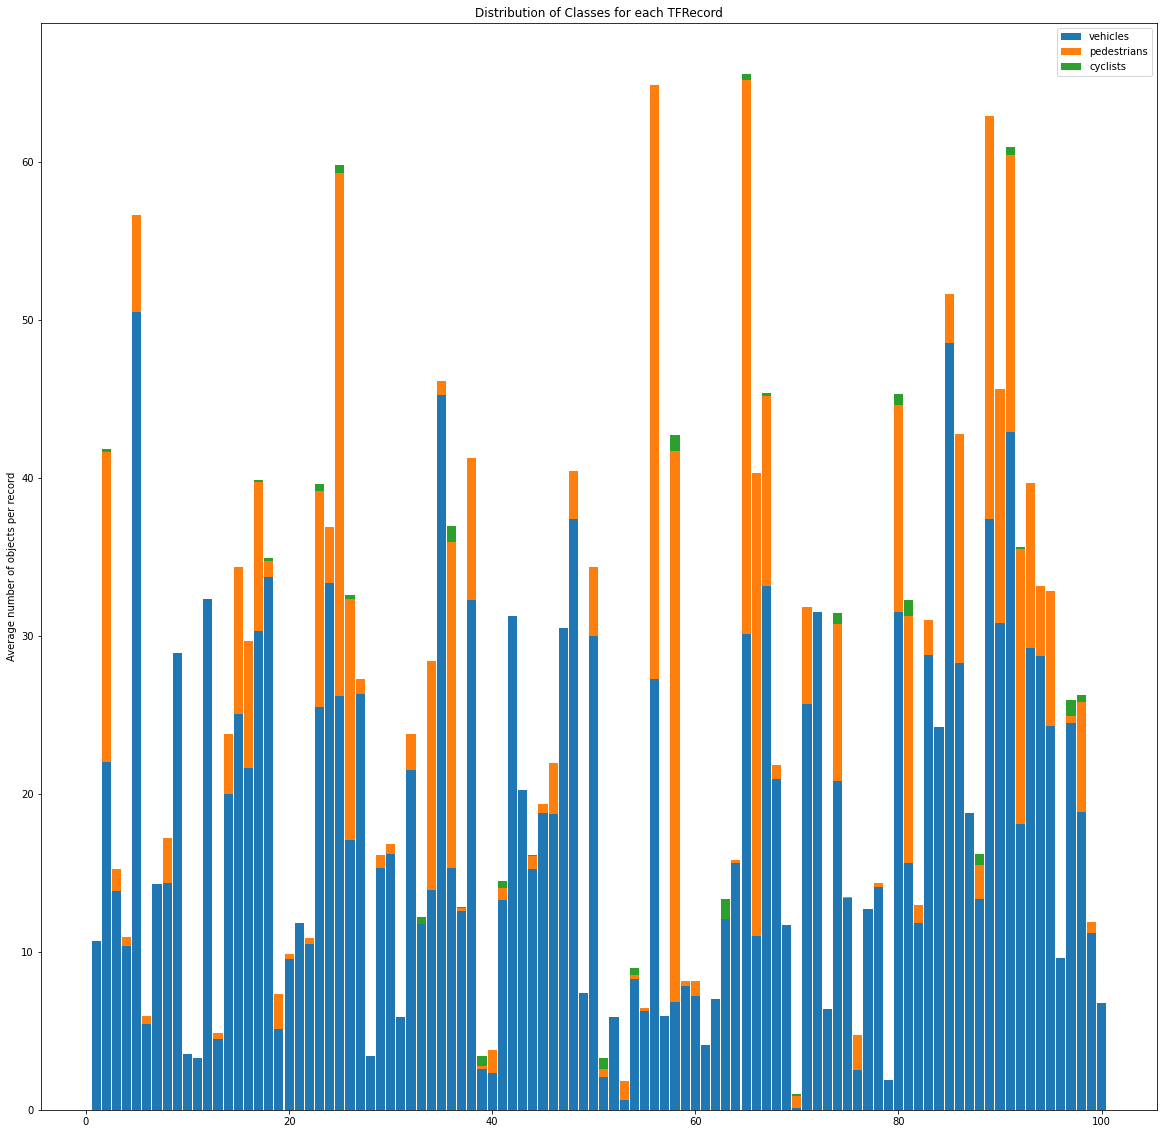

In [40]:
#now make a plot to visualize the class distribution
with open('Class_Distribution_Raw.json') as f:
    class_data = json.load(f)
    
labels = []
vehicles = []
pedestrians = []
cyclists = []

for i, record in enumerate(class_data):
    labels.append(i+1)
    vehicles.append(class_data[record]['1'])
    pedestrians.append(class_data[record]['2'])
    cyclists.append(class_data[record]['4'])

vehicles = np.array(vehicles)
pedestrians = np.array(pedestrians)
cyclists = np.array(cyclists)

fig, ax = plt.subplots(figsize=(20, 20))
width = 0.9

ax.bar(x, vehicles, width, label = 'vehicles', align = 'center')
ax.bar(x, pedestrians, width, bottom = vehicles, label = 'pedestrians', align='center')
ax.bar(x, cyclists, width, bottom = pedestrians + vehicles, label = 'cyclists', align = 'center')

ax.set_ylabel('Average number of objects per record')
ax.set_title('Distribution of Classes for each TFRecord')
ax.legend()

plt.show()